# Ex 7-1. Transfer Learning with GAP

## Global Average Pooling 

#### ResNet50 convolutional base

In [1]:
from keras.applications import ResNet50
resnet=ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)


Using TensorFlow backend.


102858752/102853048 [==============================] - 35s 0us/step


In [2]:
resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

- Output layer 전 단계에 Global Average Pooling(GAP) layer가 있음

![](https://alexisbcook.github.io/assets/global_average_pooling.png)

- 마지막 layer에서 flatten을 통해 fully-connected layer 대신 GAP layer를 사용
- 하나의 channel(feature map)의 값을 모두 평균을 취하는 layer
- fully-connected layer로 연결되기 전에 node 개수를 줄여 학습해야 할 weight의 수를 획기적으로 줄임
- fully-connected layer 이전 단계들에서 feature가 충분히 학습되었다고 판단
- overfitting의 가능성을 낮추고 획기적으로 빠르게 학습 가능 


#### VGG16의 convolution base에 global average pooling layer를 사용하여 feature extraction

In [3]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 6s 0us/step


In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [5]:
# train, validation, test 이미지가 들어있는 폴더 경로를 지정
train_dir = './data/cats_and_dogs_small/train'
validation_dir = './data/cats_and_dogs_small/validation'
test_dir = './data/cats_and_dogs_small/test'

In [6]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
model = Sequential()
model.add(conv_base)
model.add(GlobalAveragePooling2D())

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [8]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
train_features.shape, train_labels.shape

((2000, 512), (2000,))

In [10]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim= 512))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=100,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/100
2000/2000 [==============================] - 1s 553us/step - loss: 0.6614 - acc: 0.6135 - val_loss: 0.6333 - val_acc: 0.7210
Epoch 2/100
2000/2000 [==============================] - 0s 130us/step - loss: 0.6172 - acc: 0.7370 - val_loss: 0.5964 - val_acc: 0.7820
Epoch 3/100
2000/2000 [==============================] - 0s 125us/step - loss: 0.5829 - acc: 0.7780 - val_loss: 0.5643 - val_acc: 0.8140
Epoch 4/100
2000/2000 [==============================] - 0s 124us/step - loss: 0.5526 - acc: 0.7905 - val_loss: 0.5373 - val_acc: 0.8290
Epoch 5/100
2000/2000 [==============================] - 0s 127us/step - loss: 0.5279 - acc: 0.7970 - val_loss: 0.5150 - val_acc: 0.8320
Epoch 6/100
2000/2000 [==============================] - 0s 123us/step - loss: 0.5064 - acc: 0.8055 - val_loss: 0.4944 - val_acc: 0.8360
Epoch 7/100
2000/2000 [==============================] - 0s 123us/step - loss: 0.4877 - acc: 0.8110 - val_loss: 0.4772 - val_acc: 

2000/2000 [==============================] - 0s 126us/step - loss: 0.2590 - acc: 0.8980 - val_loss: 0.2743 - val_acc: 0.8870
Epoch 61/100
2000/2000 [==============================] - 0s 123us/step - loss: 0.2578 - acc: 0.9000 - val_loss: 0.2709 - val_acc: 0.8890
Epoch 62/100
2000/2000 [==============================] - 0s 127us/step - loss: 0.2564 - acc: 0.9005 - val_loss: 0.2709 - val_acc: 0.8900
Epoch 63/100
2000/2000 [==============================] - 0s 123us/step - loss: 0.2553 - acc: 0.9005 - val_loss: 0.2695 - val_acc: 0.8880
Epoch 64/100
2000/2000 [==============================] - 0s 122us/step - loss: 0.2537 - acc: 0.9020 - val_loss: 0.2681 - val_acc: 0.8930
Epoch 65/100
2000/2000 [==============================] - 0s 129us/step - loss: 0.2531 - acc: 0.8985 - val_loss: 0.2694 - val_acc: 0.8900
Epoch 66/100
2000/2000 [==============================] - 0s 120us/step - loss: 0.2519 - acc: 0.9025 - val_loss: 0.2686 - val_acc: 0.8910
Epoch 67/100
2000/2000 [=======================

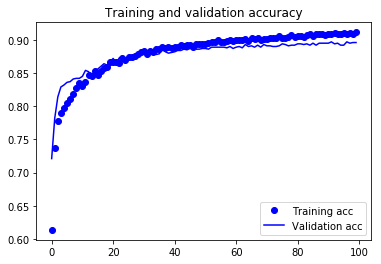

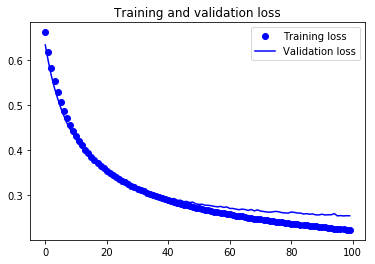

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()